In [1]:
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import cv2

<h1 href="Background">Background</h1>

As humans, it's quite easy for us to identify petals on a flower. We can see the edges of the petals, the shapes, and count how many there are. It's easy for us to pick them out from a busy picture. This is not the case for computers, which need some extra help when it comes to identifying objects in an image.

Neural networks can mimic this ability using **Convolutions**. Convolutions enable computers to augment an image using matrix multiplication and with some specific kernels (filters), we can do some pretty cool things with them.

Lets dive deeper into how convolutions work.


### What does a CNN do?

A CNN is a type of neural network which is designed to process image data. It works by moving an $n\times m$ sized kernel (matrix) over an input image and performs element wise multiplication over an $n \times m$ sized portion of your image. In this case, we have an input image of 5x5, and a kernel of 3x3.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution.png" width="600" alt="convolution example"  />
</center>

A CNN layer will compute element wise multiplication over a 3x3 window (same size as kernel) on the input image. This means the top left pixel of the input image is multiplied by the top left pixel of the kernel, and so on.

#### What are we computing?

These values are the brightness values of each pixel! They range between 0-255, and in this case because it's just one array, it means we are working with just one channel. Normally this is a grayscale image, whereas a three channel image would have three arrays with values ranging between 0-255 and we would perform convolutions over each channel. That will be discussed in a future lab.

In the end, the multiplied values are all added together to become the top left pixel value of the output image.


### Second step

We now *shift* the kernel one step right on the input image, and recalculate the element wise multiplication of our kernel with the new 3x3 window on the input image. This produces the next pixel value of our output image. The number of pixels we shift by is referred to as the `stride`, and in this example it is `1`.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution-1.png" width="600" alt="convolution example 2"  />
</center>

We can continue to shift our window over the input image until we have covered the entire image. Now we will have an output image of 3x3 which we can pass to the next layer. This whole process is known as convolution, which is where Convolutional Neural Networks get their name.


### Size of output image

Notice that the resulting image is 3x3, compared to our input image of 5x5. This is because our kernel is 3x3 and the pixels in the output image are centered around the interior pixels of the input image. For each pixel in our output image, it took in 9 pixels from the input image. For the border pixels in the input image, there are not enough pixels surrounding it to calculate an output value.

We can calculate the output image size using the following formula:

$$M\_{out} = M\_{in} - (K - 1)$$

Where $M$ represents the width of the input image (it can also represent the height, if our images are square).

In the above example,

$$
M\_{in} = 5\\\\\\\\
K = 3 \\\\\\\\
M\_{out} = 5 - (3 - 1) = 3
$$

The final output is shown below.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/convolution.gif" width="700" alt="convolution example 3"  />
</center>

### Why do this?

By performing these convolutions, we are able to extract features such as horizontal or vertical lines, edges, and more from an image. For example, the above kernel is known as a Prewitt kernel (we will go over this in this lab) and it specifically looks for vertical lines in images.


In [3]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"
data_dir = keras.utils.get_file(origin=dataset_url,
                                fname='flower_photos',
                                untar=True)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The daisy folder has 633 pictures
The dandelion folder has 898 pictures
The roses folder has 641 pictures
The tulips folder has 799 pictures
3670 total images


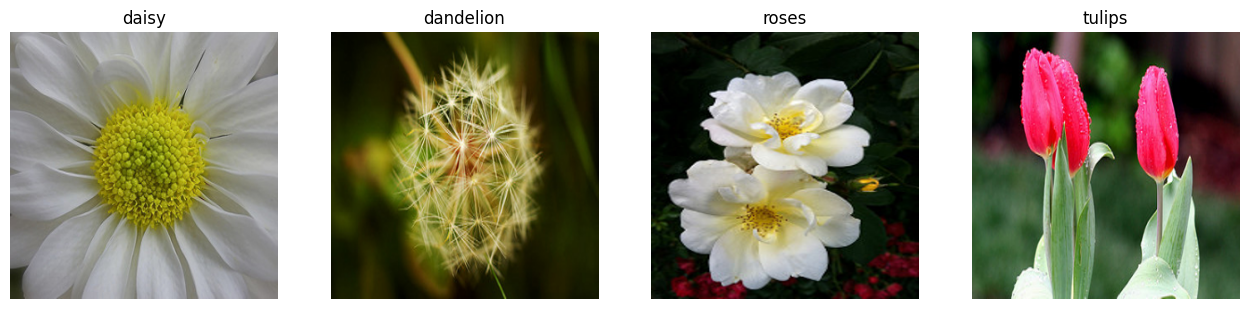

In [4]:
pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name
    
    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')
    
    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

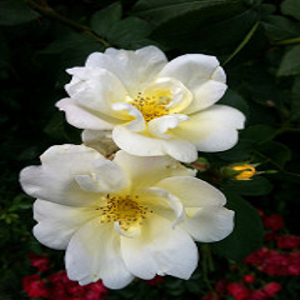

In [5]:
img = pics[2]
img

<h1 href="Exercises">Exercise: Playing with kernels</h1>

Now that we have our images, lets play around with the CNN tools we learned.

In this section, we will see what kernels can do for us. See here for more information: [https://en.wikipedia.org/wiki/Feature\_(computer_vision)](https://en.wikipedia.org/wiki/Feature_\(computer_vision\)?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

## Types of kernels

There exist many kernels used in Computer Vision, and we'll explore some of them and see what they do with our images.

### Edge detection Kernels

[**Prewitt Operator**](https://en.wikipedia.org/wiki/Prewitt_operator?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

This computes an approximation of the gradient between pixels in an image. It's commonly used for edge detection.

This operator convolves two kernels with an input image, and then approximates the gradient.

\begin{align\*}
G_x = \begin{bmatrix}
1 & 0 & -1\\\\\\\\
1 & 0 & -1\\\\\\\\
1 & 0 & -1\\\\\\\\
\end{bmatrix} \* \text{Img} \quad
G_y = \begin{bmatrix}
1 & 1 & 1\\\\\\\\
0 & 0 & 0\\\\\\\\
\-1 & -1 & -1\\\\\\\\
\end{bmatrix} \* \text{Img}
\end{align\*}

[**Sobel Operator**](https://en.wikipedia.org/wiki/Sobel_operator?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)\
The Sobel operator performs edge detection just like the Prewitt operator, except with slightly different kernels.

\begin{align\*}
G_x = \begin{bmatrix}
1 & 0 & -1\\\\\\\\
2 & 0 & -2\\\\\\\\
1 & 0 & -1\\\\\\\\
\end{bmatrix} \* \text{Img} \quad
G_y = \begin{bmatrix}
1 & 2 & 1\\\\\\\\
0 & 0 & 0\\\\\\\\
\-1 & -2 & -1\\\\\\\\
\end{bmatrix} \* \text{Img}
\end{align\*}

Where:

*   $G_x$ represents the horizontal gradient approximations;
*   $G_y$ represents the vertical gradient approximations;
*   Img is the original input image.

To get the edges, we combine the two gradient approximations from above to produce a gradient magnitude $G$ using:

\begin{align\*}
G = \sqrt{G_x^2 + G_y^2}
\end{align\*}

Which will be a pixel value that is large when there is an edge (large change in pixel brightness) and small when there is a smooth transition between pixels.

Lets try to implement the Sobel operator using Keras and Numpy.


<h1 href="#E1">Exercise 1: Implementing Edge Detection</h1>


In [6]:
# Lets define our custom kernels for the horizontal and vertical gradients
def v_grad(shape, dtype=None):
    # Here we use a single numpy array to define our x gradient kernel
    grad = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]).reshape((3, 3, 1, 1))
    # this line is quite important, we are saying we want one 3x3 kernel each for one channel of pixels (grayscale)
    
    # We check to make sure the shape of our kernel is the correct shape
    # according to the initialization of the Convolutional layer below
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

def h_grad(shape, dtype=None):
    grad = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
        ]).reshape((3, 3, 1, 1))
    
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

In [7]:
# We define the input layer of our Neural Network
# to take in an image of 300x300 with 1 channel
# Both our models can share this, as it will not change between the two

input_layer = layers.Input(shape=(img_width, img_height, 1))

h_conv = layers.Conv2D(filters=1, # the number of kernels we are using, kernel and filter are interchangeable terms
                       kernel_size=3,
                       kernel_initializer=h_grad,
                       strides=1,
                       padding='valid')  # 'valid' means no padding

v_conv = layers.Conv2D(filters=1,
                       kernel_size=3,
                       kernel_initializer=v_grad,
                       strides=1,
                       padding='valid')


h_model = keras.Sequential([input_layer, h_conv])
v_model = keras.Sequential([input_layer, v_conv])

In [8]:
h_model.summary()
v_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 1)    │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 298, 298, 1)    │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
gray = ImageOps.grayscale(img)

# We need to add 1 dimension to our input image which represents the batch size
# In this case, we just want to process 1 image.
input_img = np.array(gray).reshape((1, img_width, img_height, 1))

out_d = h_model.layers[0].output_shape[1:]

# Pass our input image into each model, and return
# the output with a shape of (298,298,1) in variables named `Gy` and `Gx`.
# WRITE YOUR CODE HERE
Gx = h_model.predict(input_img).reshape(out_d)
Gy = v_model.predict(input_img).reshape(out_d)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [15]:
G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))

NameError: name 'Gx' is not defined

NameError: name 'Gx' is not defined

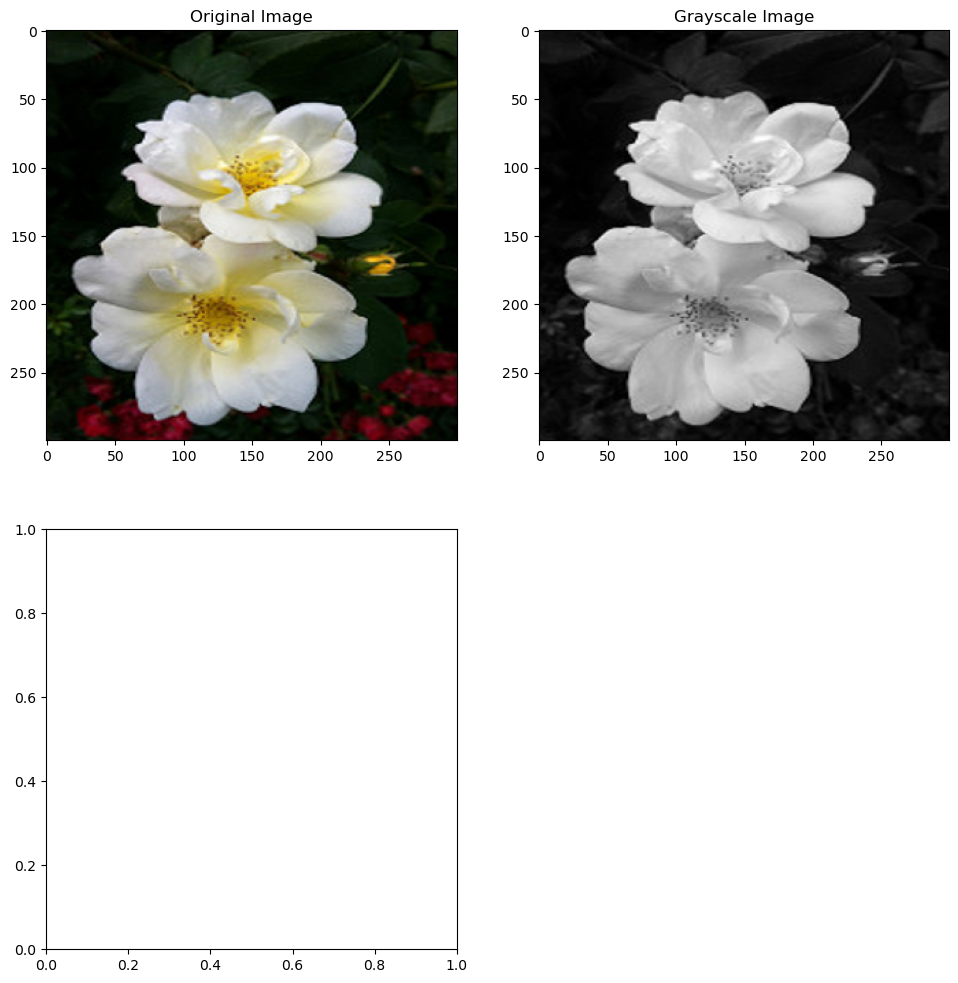

In [17]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(Gx.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Horizontal Gradient")
plt.subplot(2, 3, 5)
plt.imshow(Gy.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Vertical Gradient")
plt.subplot(2, 3, 6)
plt.imshow(G, cmap=plt.get_cmap('gray'))
plt.title("Image after Sobel Operator")
plt.show()

Congratulations! You now know how to implement a simple Prewitt (or Sobel) operator in a Neural Network and use it to detect edges in the image. Recall that these kernels were specifically designed for edge detection in computer vision applications. When you develop your own Convolutional Neural Networks in the future, you will most likely delegate initializing and optimizing the many kernels to Keras and you won't have to define the kernel values manually.

<h2 href="Exercise-2">Exercise 2: Corner and Blob detection</h2>

In computer vision, we can perform corner detection on images which could then be used to extract certain useful features or infer the contents of the image. You can learn more about it [here](https://en.wikipedia.org/wiki/Corner_detection?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

Blob detection is when you want to obtain regions within an image that differ in properties, such as brightness or color. In those regions, properties are relatively constant. You can learn more about this [here](https://en.wikipedia.org/wiki/Blob_detection?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

### [Difference of Gaussians (DoG)](https://en.wikipedia.org/wiki/Difference_of_Gaussians?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)

This is a method for both corner *and* blob detection. The way it works is by convolving two Gaussian kernels with different variances (sigma) over an image which will produce two blurred versions of the input image. We then subtract the two blurred images and get the resulting DoG processed image which should make it easy to identify corners and blobs.

The convolution can be illustrated with the following equation:

\begin{align\*}
\Gamma \_{\sigma\_1 ,sigma\_2 }(x,y)=
I \cdot \frac {1}{2\pi \sigma\_1^{2}} e^{ - \frac {x^{2}+y^{2}}{2\sigma\_1^{2}} } -
I \cdot \frac {1}{2\pi \sigma\_2^{2}} e^{ - \frac {x^{2}+y^{2}}{2\sigma\_2^{2}} }
\end{align\*}

Where

*   the first term represents the image convolved with the first Gaussian with mean $0$, variance $\sigma\_1^2$ and
*   the second term represents the image convolved with the second Gaussian with mean $0$, variance $\sigma\_2^2$.

Note that $\sigma\_2^2 > \sigma\_1^2$.


There are built in methods such as scipy's `scipy.ndimage.filters.gaussian_filter` or OpenCV's `cv2.GuassianBlur` which can perform the convolution with a gaussian kernel for you.

We can implement the `cv2.GuassianBlur` function here!


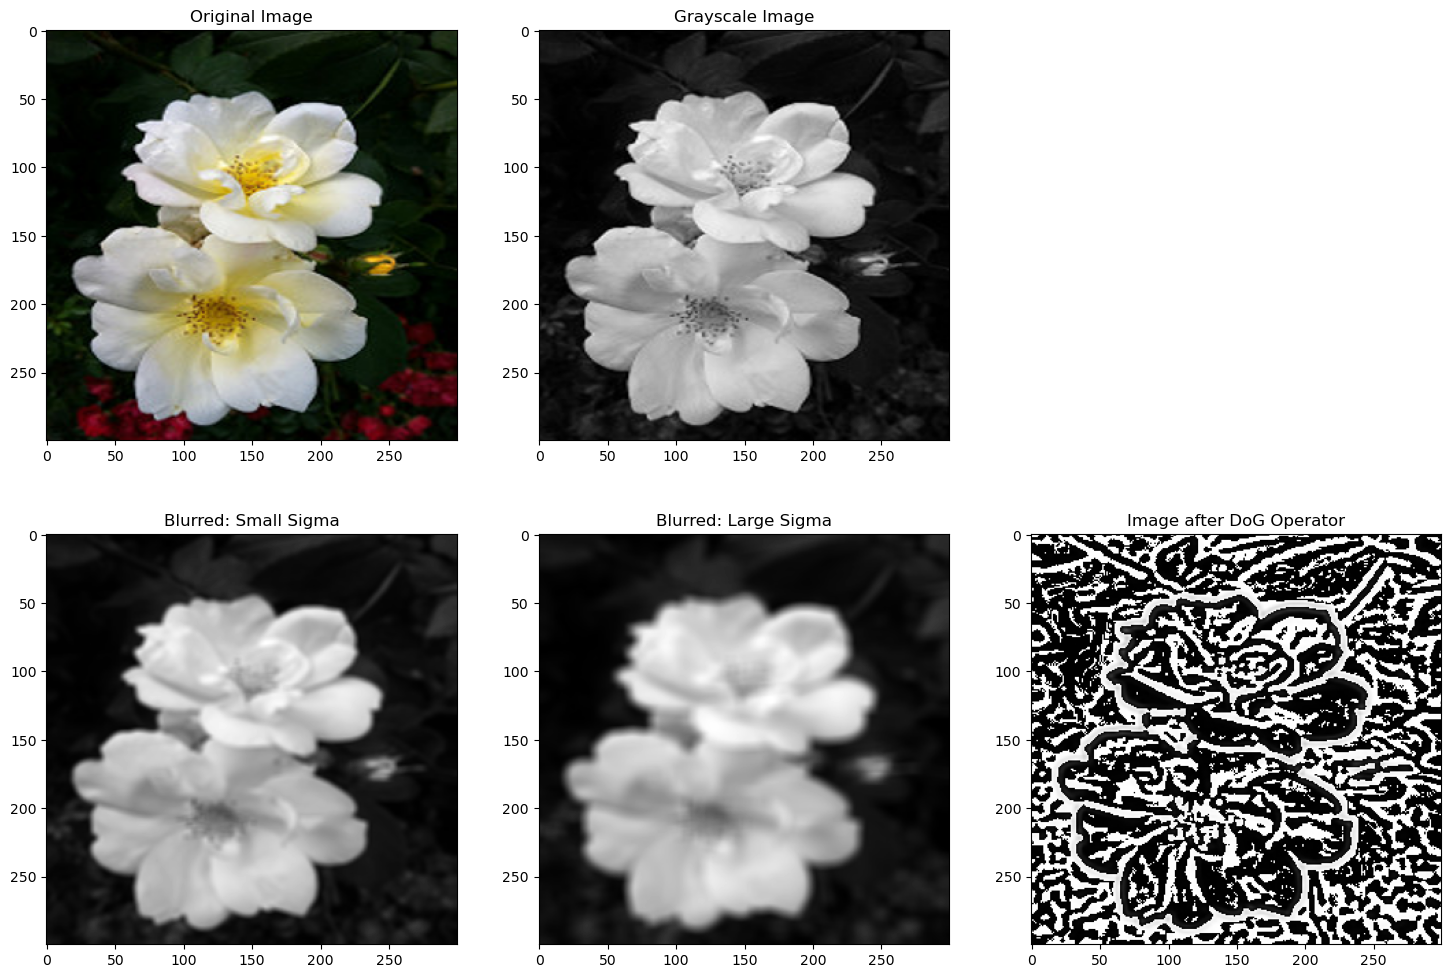

In [18]:
sigma_sm = 5
sigma_lg = 9
blurred_sm = cv2.GaussianBlur(np.array(gray), (sigma_sm, sigma_sm), sigma_sm)
blurred_lg = cv2.GaussianBlur(np.array(gray), (sigma_lg, sigma_lg), sigma_lg)

DoG = blurred_sm - blurred_lg

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap=plt.get_cmap('gray'))
plt.title("Grayscale Image")
plt.subplot(2, 3, 4)
plt.imshow(blurred_sm.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Small Sigma")
plt.subplot(2, 3, 5)
plt.imshow(blurred_lg.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Blurred: Large Sigma")
plt.subplot(2, 3, 6)
plt.imshow(DoG.astype('uint8'), cmap=plt.get_cmap('gray'))
plt.title("Image after DoG Operator")
plt.show()

With Difference of Gaussians, we can greatly enhance features within an image by applying two Gaussian kernels to the same image, and take their difference. This technique greatly helps in reducing noise in an image, and results in clearly defined corners of shapes, as well as easily identifiable blobs (regions with very similar properties).

Feel free to play around with the kernel sizes and values for `sigma_sm` and `sigma_lg` to see how those values can change our output image.


And thats it! Hopefully you gained a better understanding of image convolutions through this lab, some important kernels (filters) used in computer vision and why they are useful. You now know how we can implement them using Keras as well.

## Other kernels

This table is from [wikipedia](https://en.wikipedia.org/wiki/Feature_\(computer_vision\)?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01#Detection), which shows all the different types of methods you can use to process images and detect different features within.

|          Feature detector         | Edge | Corner | Blob | Ridge |
| :-------------------------------: | :--: | :----: | :--: | :---: |
|               Canny               |  Yes |   No   |  No  |   No  |
|               Sobel               |  Yes |   No   |  No  |   No  |
|    Harris & Stephens / Plessey    |  Yes |   Yes  |  No  |   No  |
|               SUSAN               |  Yes |   Yes  |  No  |   No  |
|            Shi & Tomasi           |  No  |   Yes  |  No  |   No  |
|       Level curve curvature       |  No  |   Yes  |  No  |   No  |
|                FAST               |  No  |   Yes  |  Yes |   No  |
|       Laplacian of Gaussian       |  No  |   Yes  |  Yes |   No  |
|      Difference of Gaussians      |  No  |   Yes  |  Yes |   No  |
|       Determinant of Hessian      |  No  |   Yes  |  Yes |   No  |
| Hessian strength feature measures |  No  |   Yes  |  Yes |   No  |
|                MSER               |  No  |   No   |  Yes |   No  |
|     Principal curvature ridges    |  No  |   No   |  No  |  Yes  |
|          Grey-level blobs         |  No  |   No   |  Yes |   No  |

## Applying our knowledge to the botanical garden

Armed with this knowledge, how would you help the botanical garden process their images to create clay molds?

I would use the image produced by the Sobel operator, as it gives us a cleaner image to work with so kids can easily paint each section.
